In [ ]:
!pip install -U transformers==4.46.2 accelerate==1.2.1 datasets evaluate seqeval sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 121.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=ce39206d027ad78db183ecb67bc612c5eb474730aa53a63ef6587e4247e0d0b5
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval
  Attempting uninstall: pyarrow
   

In [ ]:
!pip uninstall -y peft

Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0


In [ ]:
!pip install -U transformers

import transformers
print("Transformers version:", transformers.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2


Transformers version: 4.46.2


In [ ]:
!pip install -U accelerate
import accelerate
print("Accelerate version:", accelerate.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


Accelerate version: 1.2.1


In [ ]:
!pip install --upgrade transformers
!pip install --upgrade accelerate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 25.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
# CELL 0 — RUN ONCE
# Preprocessing + tokenizer + shared functions + splits + custom BART token classifier

import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    BartModel,
    BartConfig,
    DataCollatorForTokenClassification,
)
import evaluate
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -------------- CONFIG --------------
MODEL_NAME = "facebook/bart-base"   # BART model
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 3e-5
WEIGHT_DECAY = 0.01
GRADIENT_ACCUMULATION = 2
WARMUP_STEPS = 500
FP16 = True  # use mixed precision if available

# -------------- LOAD CSV --------------
df = pd.read_csv("/content/TV_Reviews(Sheet1).csv")
assert {"sentence_id", "word", "tag"}.issubset(df.columns), "CSV must have sentence_id, word, tag"

# -------------- GROUP SENTENCES --------------
sentences = []
tags = []
for _, g in df.groupby("sentence_id"):
    sentences.append(g["word"].tolist())
    tags.append(g["tag"].tolist())

print(f"Total sentences: {len(sentences)}")

# -------------- LABELS --------------
label_list = sorted(list({t for seq in tags for t in seq}))
if len(label_list) != 3:
    print("Warning: found", len(label_list), "unique labels in data. Expected 3.")
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}
num_labels = len(label_list)
print("Labels:", label_list)

# Convert tags -> label IDs
label_ids = [[label2id[t] for t in seq] for seq in tags]

# -------------- HF Dataset --------------
hf_ds = Dataset.from_dict({"tokens": sentences, "labels": label_ids})

# -------------- TOKENIZER --------------
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME,
    use_fast=True,
    add_prefix_space=True  # important for RoBERTa/BART style tokenization
)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )
    aligned_labels = []
    for i, lab in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        prev_word_idx = None
        label_ids_per_token = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids_per_token.append(-100)
            elif word_idx != prev_word_idx:
                # first token of the word
                label_ids_per_token.append(lab[word_idx])
            else:
                # continuation token → ignore in loss
                label_ids_per_token.append(-100)
            prev_word_idx = word_idx
        aligned_labels.append(label_ids_per_token)
    tokenized_inputs["labels"] = aligned_labels
    return tokenized_inputs

# -------------- METRICS helpers --------------
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    preds, labels = p
    preds = np.argmax(preds, axis=2)

    true_preds = [
        [label_list[p] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(pred_seq, lab_seq) if l != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# -------------- K-Fold splits (random) --------------
kf = KFold(n_splits=6, shuffle=True, random_state=None)
splits = list(kf.split(hf_ds))
print("Prepared 6 random folds (shuffle=True).")

# -------------- CUSTOM BART TOKEN-CLASSIFICATION MODEL --------------
class BartTokenClassifier(nn.Module):
    """
    Simple BART encoder + token classification head.
    Compatible with HuggingFace Trainer.
    """
    def __init__(self, model_name, num_labels, id2label, label2id):
        super().__init__()
        # load config with token-classification info
        self.config = BartConfig.from_pretrained(
            model_name,
            num_labels=num_labels,
            id2label=id2label,
            label2id=label2id,
        )
        self.num_labels = num_labels

        # BART encoder-decoder; we will use encoder outputs
        self.bart = BartModel.from_pretrained(model_name, config=self.config)

        # classifier head
        hidden_size = self.config.d_model  # BART hidden size
        dropout_prob = (
            self.config.classifier_dropout
            if getattr(self.config, "classifier_dropout", None) is not None
            else self.config.dropout
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        labels=None,
        **kwargs,
    ):
        # Newer Trainer/accelerate may send this; BartModel does NOT accept it
        if "num_items_in_batch" in kwargs:
            kwargs.pop("num_items_in_batch")

        # Use encoder outputs for token classification
        outputs = self.bart(
            input_ids=input_ids,
            attention_mask=attention_mask,
            **kwargs,
        )
        sequence_output = outputs.last_hidden_state  # (batch, seq, hidden)
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)    # (batch, seq, num_labels)

        loss = None
        if labels is not None:
            # CrossEntropyLoss ignores positions where label == -100 (our padding)
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(
                logits.view(-1, self.num_labels),
                labels.view(-1),
            )

        return {"loss": loss, "logits": logits}


Total sentences: 12044
Labels: ['BOC', 'IOC', 'O']


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Prepared 6 random folds (shuffle=True).


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

/tmp/ipython-input-1794955432.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 1 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.454300,0.556999,0.221865,0.230659,0.226177,0.769646
2,1.105200,0.499420,0.301276,0.315664,0.308302,0.796645
3,0.969100,0.460414,0.362138,0.346227,0.354004,0.813496
4,0.870700,0.458434,0.371824,0.384432,0.378023,0.816521
5,0.807600,0.459316,0.382501,0.398758,0.390461,0.818589


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 1)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.35379424691200256, 'eval_precision': 0.4229743401085257, 'eval_recall': 0.4400114810562572, 'eval_f1': 0.43132473622508793, 'eval_accuracy': 0.8564024949550542, 'eval_runtime': 28.2263, 'eval_samples_per_second': 355.555, 'eval_steps_per_second': 22.249, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4593163728713989, 'eval_precision': 0.3825011452130096, 'eval_recall': 0.3987583572110793, 'eval_f1': 0.3904606032265606, 'eval_accuracy': 0.8185891544117647, 'eval_runtime': 5.8175, 'eval_samples_per_second': 345.163, 'eval_steps_per_second': 21.659, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.67      0.58      0.62      8829
         IOC       0.77      0.76      0.76     31973
           O       0.90      0.92      0.91     90022

    accuracy                           0.86    130824
   macro avg       0.78      0.75     

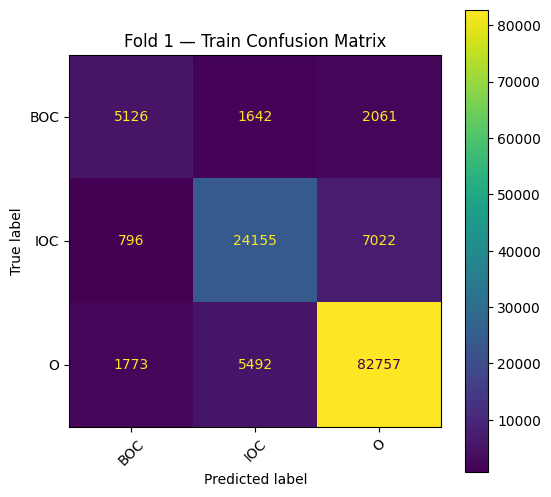

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.63      0.53      0.57      1777
         IOC       0.70      0.68      0.69      6317
           O       0.87      0.90      0.88     18018

    accuracy                           0.82     26112
   macro avg       0.73      0.70      0.72     26112
weighted avg       0.81      0.82      0.82     26112



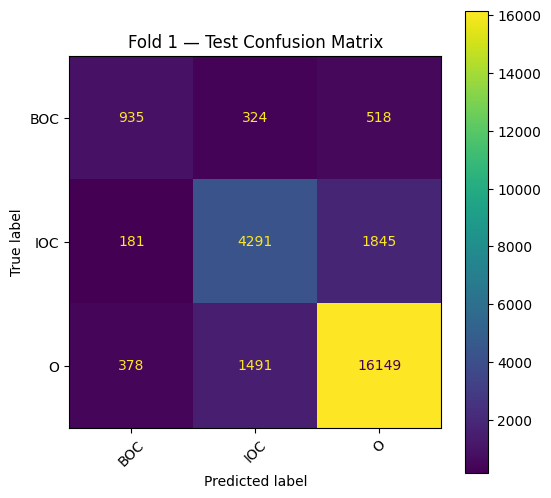

In [ ]:
# CELL 1 — FOLD 1 WITH BART

fold_idx = 1
train_idx, test_idx = splits[0]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# ----------------- MODEL (CUSTOM BART TOKEN CLASSIFIER) -----------------
# BartTokenClassifier must be defined in CELL 0
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ----------------- TRAINING ARGS -----------------
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",                    # ✅ new name in transformers 4.57.3
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

# ----------------- EVALUATION -----------------
print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# ---------------- Predictions & Confusion Matrices ----------------
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

# Train confusion matrix
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
cm_labels = label_list  # sorted label strings
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels, normalize=None)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test confusion matrix
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels, normalize=None)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10036 [00:00<?, ? examples/s]

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

/tmp/ipython-input-2857457197.py:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 2 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.448100,0.570450,0.222952,0.211714,0.217188,0.764826
2,1.113900,0.498871,0.305556,0.306289,0.305922,0.799278
3,0.974200,0.462790,0.358146,0.367259,0.362645,0.811338
4,0.874700,0.462516,0.357443,0.367739,0.362518,0.814372
5,0.812500,0.462411,0.354620,0.375900,0.364950,0.815217


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 2)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.35538941621780396, 'eval_precision': 0.4206158952609257, 'eval_recall': 0.43601261588454554, 'eval_f1': 0.42817588812238966, 'eval_accuracy': 0.8561420932009167, 'eval_runtime': 28.7051, 'eval_samples_per_second': 349.624, 'eval_steps_per_second': 21.878, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4624108076095581, 'eval_precision': 0.3546195652173913, 'eval_recall': 0.37590014402304367, 'eval_f1': 0.3649498951293405, 'eval_accuracy': 0.8152173913043478, 'eval_runtime': 5.5231, 'eval_samples_per_second': 363.565, 'eval_steps_per_second': 22.813, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.66      0.59      0.62      8856
         IOC       0.78      0.74      0.76     32004
           O       0.90      0.92      0.91     90040

    accuracy                           0.86    130900
   macro avg       0.78      0.75   

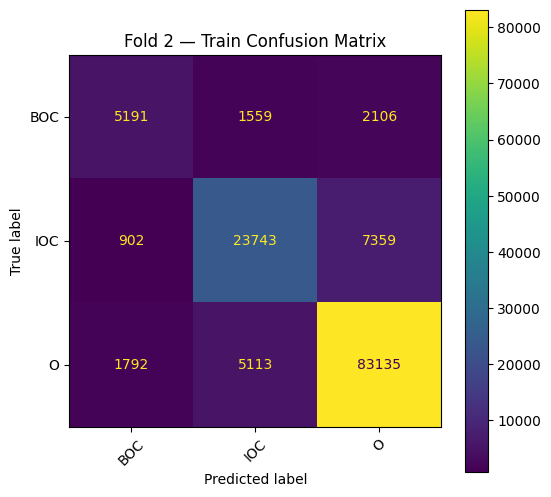

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.53      0.56      1750
         IOC       0.71      0.66      0.68      6286
           O       0.87      0.90      0.88     18000

    accuracy                           0.82     26036
   macro avg       0.72      0.70      0.71     26036
weighted avg       0.81      0.82      0.81     26036



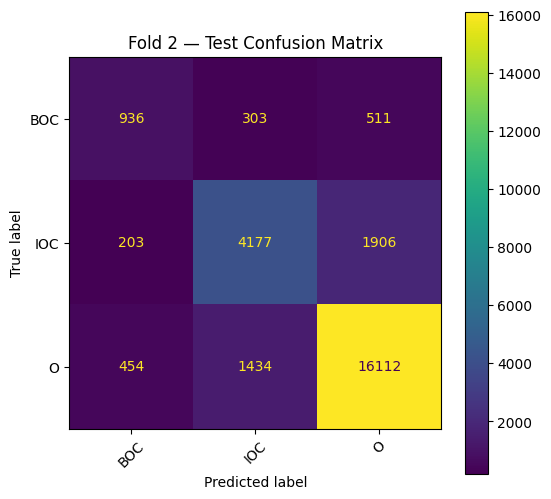

In [ ]:
# CELL 2 — FOLD 2 WITH BART

fold_idx = 2
train_idx, test_idx = splits[1]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# ----------------- MODEL (CUSTOM BART TOKEN CLASSIFIER) -----------------
# BartTokenClassifier is defined in CELL 0
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ----------------- TRAINING ARGS -----------------
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",                    # ✅ correct key for transformers 4.57.3
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# ---------------- Confusion matrices ----------------
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

cm_labels = label_list  # sorted list of label names

# ---- Train confusion matrix ----
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))

cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# ---- Test confusion matrix ----
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

/tmp/ipython-input-2861625175.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 3 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.449800,0.569001,0.240671,0.272943,0.255793,0.762143
2,1.116600,0.495673,0.295702,0.271517,0.283094,0.797690
3,0.964600,0.467085,0.358142,0.377556,0.367593,0.813699
4,0.875100,0.454338,0.364348,0.376129,0.370145,0.818157
5,0.809100,0.460138,0.368759,0.382786,0.375642,0.818428


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 3)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.3564557135105133, 'eval_precision': 0.4244245169640381, 'eval_recall': 0.4396246289380446, 'eval_f1': 0.4318908748824083, 'eval_accuracy': 0.8555807196943701, 'eval_runtime': 28.7083, 'eval_samples_per_second': 349.62, 'eval_steps_per_second': 21.875, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4601379334926605, 'eval_precision': 0.36875858909757214, 'eval_recall': 0.3827864954826438, 'eval_f1': 0.37564162389174055, 'eval_accuracy': 0.8184284994379192, 'eval_runtime': 5.5854, 'eval_samples_per_second': 359.332, 'eval_steps_per_second': 22.559, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.65      0.58      0.61      8822
         IOC       0.78      0.74      0.76     31962
           O       0.90      0.92      0.91     90355

    accuracy                           0.86    131139
   macro avg       0.78      0.75      

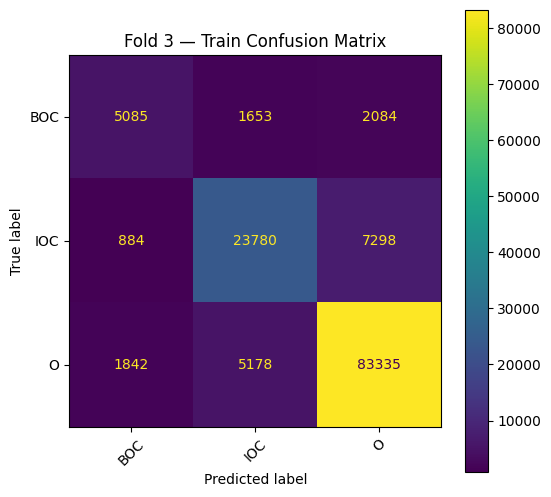

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.60      0.52      0.56      1784
         IOC       0.71      0.68      0.70      6328
           O       0.87      0.90      0.88     17685

    accuracy                           0.82     25797
   macro avg       0.73      0.70      0.71     25797
weighted avg       0.81      0.82      0.82     25797



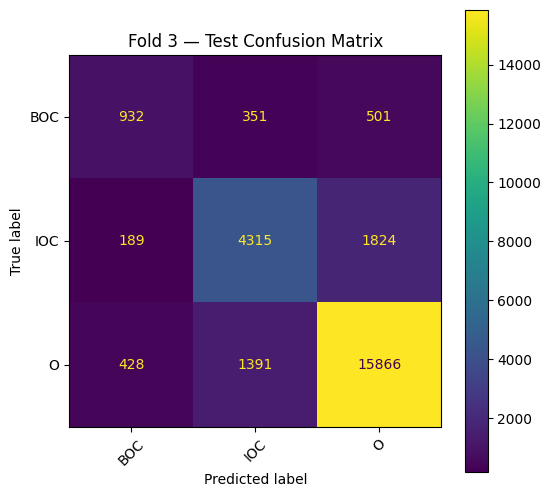

In [ ]:
# CELL 3 — FOLD 3 WITH BART

fold_idx = 3
train_idx, test_idx = splits[2]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# Model
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training args
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

cm_labels = label_list

# Train
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

/tmp/ipython-input-802174592.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 4 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.450300,0.566617,0.224303,0.270283,0.245156,0.761610
2,1.107400,0.486875,0.325222,0.333653,0.329384,0.803442
3,0.970000,0.450624,0.333811,0.335574,0.334690,0.817155
4,0.877000,0.445562,0.366279,0.362938,0.364601,0.823570
5,0.815000,0.439842,0.368542,0.383581,0.375912,0.821381


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 4)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.358714759349823, 'eval_precision': 0.42127893147927914, 'eval_recall': 0.4401223358501386, 'eval_f1': 0.43049453117696546, 'eval_accuracy': 0.8543272499484351, 'eval_runtime': 28.2865, 'eval_samples_per_second': 354.834, 'eval_steps_per_second': 22.201, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.43984219431877136, 'eval_precision': 0.3685424354243542, 'eval_recall': 0.38358137301968315, 'eval_f1': 0.37591155022347683, 'eval_accuracy': 0.8213805554488534, 'eval_runtime': 5.5015, 'eval_samples_per_second': 364.81, 'eval_steps_per_second': 22.903, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.67      0.58      0.62      8833
         IOC       0.77      0.75      0.76     31915
           O       0.90      0.92      0.91     90155

    accuracy                           0.85    130903
   macro avg       0.78      0.75    

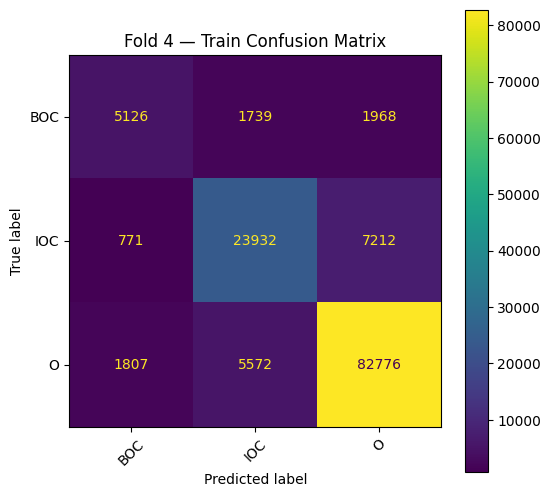

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.61      0.51      0.56      1773
         IOC       0.71      0.69      0.70      6375
           O       0.87      0.90      0.89     17885

    accuracy                           0.82     26033
   macro avg       0.73      0.70      0.72     26033
weighted avg       0.82      0.82      0.82     26033



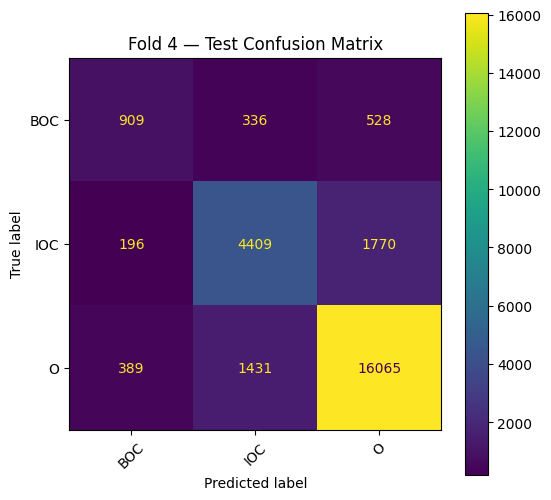

In [ ]:
# CELL 4 — FOLD 4 WITH BART

fold_idx = 4
train_idx, test_idx = splits[3]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# Model
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training args
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

cm_labels = label_list

# Train
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


In [ ]:
# Save Fold-4 model after training
fold4_model.save_pretrained("./fold4")
tokenizer.save_pretrained("./fold4")


NameError: name 'fold4_model' is not defined

Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

/tmp/ipython-input-1729924517.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 5 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.453800,0.599985,0.201538,0.250598,0.223407,0.750789
2,1.111500,0.495697,0.323814,0.336203,0.329892,0.799825
3,0.969900,0.459413,0.335681,0.341942,0.338782,0.815232
4,0.868000,0.454743,0.356133,0.373505,0.364613,0.817362
5,0.809600,0.459091,0.369779,0.376853,0.373283,0.818808


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 5)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.35264062881469727, 'eval_precision': 0.4268455098934551, 'eval_recall': 0.42917264466762317, 'eval_f1': 0.4280059140554204, 'eval_accuracy': 0.8572357997382299, 'eval_runtime': 29.3683, 'eval_samples_per_second': 341.763, 'eval_steps_per_second': 21.384, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.45909127593040466, 'eval_precision': 0.3697794462693571, 'eval_recall': 0.3768531802965088, 'eval_f1': 0.3732828043581241, 'eval_accuracy': 0.818807775706623, 'eval_runtime': 5.6051, 'eval_samples_per_second': 358.064, 'eval_steps_per_second': 22.479, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.67      0.57      0.62      8833
         IOC       0.78      0.74      0.76     31826
           O       0.90      0.93      0.91     89990

    accuracy                           0.86    130649
   macro avg       0.78      0.75     

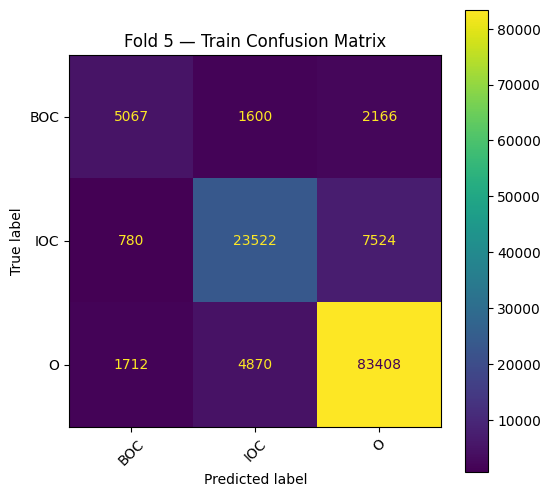

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.50      0.54      1773
         IOC       0.72      0.68      0.70      6464
           O       0.87      0.90      0.89     18050

    accuracy                           0.82     26287
   macro avg       0.73      0.69      0.71     26287
weighted avg       0.81      0.82      0.82     26287



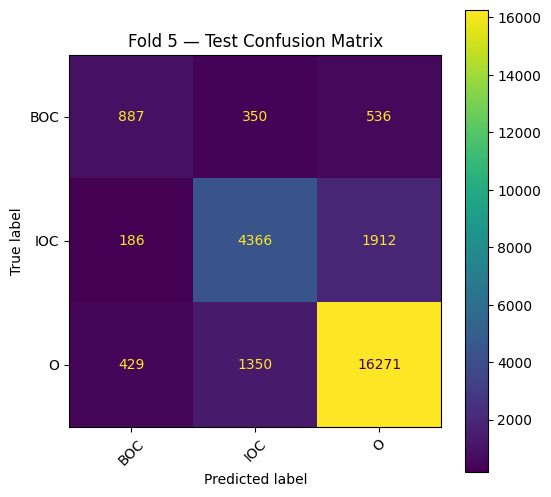

In [ ]:
# CELL 5 — FOLD 5 WITH BART

fold_idx = 5
train_idx, test_idx = splits[4]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# Model
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training args
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

cm_labels = label_list

# Train
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


Map:   0%|          | 0/10037 [00:00<?, ? examples/s]

Map:   0%|          | 0/2007 [00:00<?, ? examples/s]

/tmp/ipython-input-2095020293.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training Fold 6 (epochs=5) ...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,1.450900,0.583548,0.207598,0.258481,0.230262,0.751209
2,1.113800,0.503707,0.296157,0.301959,0.299030,0.794462
3,0.967400,0.465197,0.330773,0.349737,0.339991,0.806815
4,0.880500,0.468638,0.336406,0.348782,0.342482,0.809950
5,0.809200,0.470832,0.346013,0.360726,0.353216,0.811386


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



📊 Trainer Evaluate (Fold 6)



--- TRAIN METRICS (from trainer.evaluate) ---
{'eval_loss': 0.3563220500946045, 'eval_precision': 0.42847787445036956, 'eval_recall': 0.4381517267770018, 'eval_f1': 0.4332608078705894, 'eval_accuracy': 0.8563895020848663, 'eval_runtime': 28.3394, 'eval_samples_per_second': 354.171, 'eval_steps_per_second': 22.16, 'epoch': 5.0}

--- TEST METRICS (from trainer.evaluate) ---
{'eval_loss': 0.4708315432071686, 'eval_precision': 0.346012832263978, 'eval_recall': 0.3607262302914477, 'eval_f1': 0.3532163742690058, 'eval_accuracy': 0.8113856149894227, 'eval_runtime': 5.6957, 'eval_samples_per_second': 352.373, 'eval_steps_per_second': 22.122, 'epoch': 5.0}

Train classification report:
              precision    recall  f1-score   support

         BOC       0.66      0.58      0.62      8847
         IOC       0.78      0.74      0.76     31803
           O       0.90      0.92      0.91     89814

    accuracy                           0.86    130464
   macro avg       0.78      0.75      0.

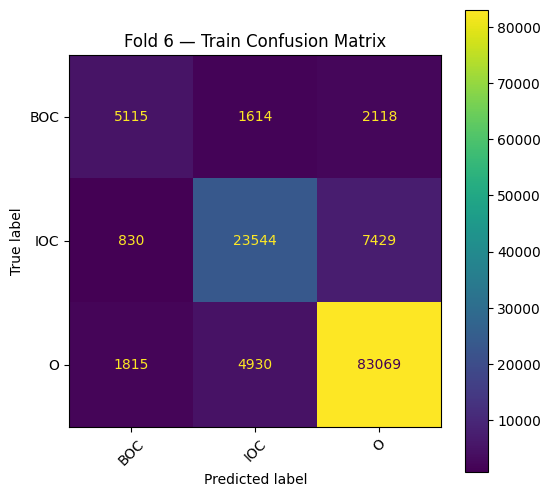

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: BOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: IOC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))



Test classification report:
              precision    recall  f1-score   support

         BOC       0.59      0.51      0.55      1759
         IOC       0.71      0.65      0.68      6487
           O       0.86      0.90      0.88     18226

    accuracy                           0.81     26472
   macro avg       0.72      0.69      0.70     26472
weighted avg       0.81      0.81      0.81     26472



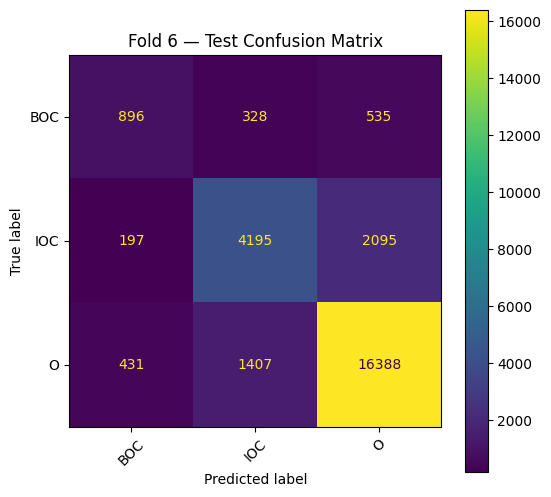

In [ ]:
# CELL 6 — FOLD 6 WITH BART

fold_idx = 6
train_idx, test_idx = splits[5]

train_data = hf_ds.select(train_idx)
test_data  = hf_ds.select(test_idx)

tokenized_train = train_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=train_data.column_names
)
tokenized_test  = test_data.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=test_data.column_names
)

# Model
model = BartTokenClassifier(
    model_name=MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training args
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification

training_args = TrainingArguments(
    output_dir=f"./fold{fold_idx}",
    eval_strategy="epoch",
    save_strategy="no",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    warmup_steps=WARMUP_STEPS,
    fp16=FP16 and torch.cuda.is_available(),
    logging_strategy="epoch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics
)

print(f"🚀 Training Fold {fold_idx} (epochs={EPOCHS}) ...")
trainer.train()

print(f"\n📊 Trainer Evaluate (Fold {fold_idx})")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_test)
train_metrics = trainer.evaluate(eval_dataset=tokenized_train)

print("\n--- TRAIN METRICS (from trainer.evaluate) ---")
print(train_metrics)
print("\n--- TEST METRICS (from trainer.evaluate) ---")
print(eval_metrics)

# Confusion matrices
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def preds_and_labels(tok_dataset):
    preds_output = trainer.predict(tok_dataset)
    preds = np.argmax(preds_output.predictions, axis=2)
    labels = preds_output.label_ids

    y_true = []
    y_pred = []
    for pred_seq, label_seq in zip(preds, labels):
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                y_true.append(id2label[int(l)])
                y_pred.append(id2label[int(p)])
    return y_true, y_pred

cm_labels = label_list

# Train
y_true_train, y_pred_train = preds_and_labels(tokenized_train)
print("\nTrain classification report:")
print(classification_report(y_true_train, y_pred_train, labels=cm_labels, zero_division=0))
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Train Confusion Matrix")
plt.show()

# Test
y_true_test, y_pred_test = preds_and_labels(tokenized_test)
print("\nTest classification report:")
print(classification_report(y_true_test, y_pred_test, labels=cm_labels, zero_division=0))
cm_test = confusion_matrix(y_true_test, y_pred_test, labels=cm_labels)
fig = plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=cm_labels)
disp.plot(ax=plt.gca(), xticks_rotation=45)
plt.title(f"Fold {fold_idx} — Test Confusion Matrix")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# -----------------------
# LOAD DATA
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id)]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]])
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]])

# -----------------------
# TOKENIZER
# -----------------------
MODEL_NAME = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["Causal Phrase"], truncation=True, padding="max_length", max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds  = test_ds.rename_column("label", "labels")

train_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])
test_ds.set_format("torch", columns=["input_ids","attention_mask","labels"])

# -----------------------
# MODEL
# -----------------------
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    pm, rm, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "weighted_precision": p,
        "weighted_recall": r,
        "weighted_f1": f1,
        "macro_precision": pm,
        "macro_recall": rm,
        "macro_f1": f1m
    }

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_bart",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

print("🚀 Training BART-base sentiment classifier...")
trainer.train()

print("\n📊 Final Test Evaluation:")
print(trainer.evaluate(test_ds))


In [ ]:
from transformers import BartForSequenceClassification


Cleaned dataset size: 6415
Train size: 5132, Test size: 1283


Map:   0%|          | 0/5132 [00:00<?, ? examples/s]

Map:   0%|          | 0/1283 [00:00<?, ? examples/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-976903784.py:138: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🚀 Training BART sentiment classifier...


Epoch,Training Loss,Validation Loss,Accuracy,Weighted Precision,Weighted Recall,Weighted F1,Macro Precision,Macro Recall,Macro F1
1,0.119400,0.032692,0.990647,0.990886,0.990647,0.990706,0.978873,0.991039,0.984818
2,0.040300,0.022283,0.992985,0.992976,0.992985,0.992980,0.989237,0.987666,0.988449
3,0.018900,0.022974,0.996103,0.996111,0.996103,0.996106,0.992816,0.994395,0.993603
4,0.008700,0.024673,0.996103,0.996111,0.996103,0.996106,0.992816,0.994395,0.993603


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning 


📊 Final Test Evaluation:


{'eval_loss': 0.02467339113354683, 'eval_accuracy': 0.9961028838659393, 'eval_weighted_precision': 0.9961110902158874, 'eval_weighted_recall': 0.9961028838659393, 'eval_weighted_f1': 0.9961060003619875, 'eval_macro_precision': 0.992816240711686, 'eval_macro_recall': 0.9943951741770534, 'eval_macro_f1': 0.9936034540351087, 'eval_runtime': 2.6035, 'eval_samples_per_second': 492.803, 'eval_steps_per_second': 61.84, 'epoch': 4.0}

📌 Generating Confusion Matrix...


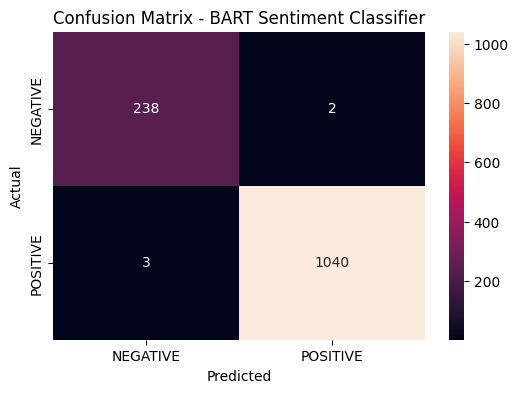

In [ ]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    BartForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------
# LOAD & CLEAN DATA
# -----------------------
df = pd.read_csv("/content/TV_Reviews_Cause_Sentiment(TV_Reviews_Cause_Sentiment).csv", encoding="latin1")

df = df[["Causal Phrase", "Sentiment"]].copy()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip()
df = df[df["Sentiment"] != ""]

label2id = {"NEGATIVE": 0, "POSITIVE": 1}
id2label = {0: "NEGATIVE", 1: "POSITIVE"}

df = df[df["Sentiment"].isin(label2id.keys())]
df["label"] = df["Sentiment"].map(label2id)
df = df.dropna()

print("Cleaned dataset size:", len(df))

# -----------------------
# TRAIN / TEST SPLIT
# -----------------------
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# -----------------------
# CONVERT TO HF DATASET
# -----------------------
train_ds = Dataset.from_pandas(train_df[["Causal Phrase", "label"]], preserve_index=False)
test_ds  = Dataset.from_pandas(test_df[["Causal Phrase", "label"]], preserve_index=False)

# Ensure no hidden index columns remain
for ds_name, ds in [("train", train_ds), ("test", test_ds)]:
    remove_cols = [c for c in ds.column_names if c.startswith("__")]
    if remove_cols:
        ds = ds.remove_columns(remove_cols)
    if ds_name == "train":
        train_ds = ds
    else:
        test_ds = ds

# -----------------------
# TOKENIZER
# -----------------------
MODEL_NAME = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["Causal Phrase"],
        truncation=True,
        padding=False,   # ✔ let DataCollator handle padding dynamically
        max_length=128
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

train_ds = train_ds.rename_column("label", "labels")
test_ds = test_ds.rename_column("label", "labels")

train_ds.set_format("torch")
test_ds.set_format("torch")

# -----------------------
# MODEL
# -----------------------
model = BartForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# -----------------------
# METRICS
# -----------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Fix shape issues
    if isinstance(logits, tuple):
        logits = logits[0]

    preds = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    pm, rm, f1m, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "weighted_precision": p,
        "weighted_recall": r,
        "weighted_f1": f1,
        "macro_precision": pm,
        "macro_recall": rm,
        "macro_f1": f1m
    }

# -----------------------
# TRAINER
# -----------------------
training_args = TrainingArguments(
    output_dir="./sentiment_bart",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# -----------------------
# TRAIN
# -----------------------
print("🚀 Training BART sentiment classifier...")
trainer.train()

# -----------------------
# FINAL EVALUATION
# -----------------------
print("\n📊 Final Test Evaluation:")
metrics = trainer.evaluate(test_ds)
print(metrics)

# -----------------------
# CONFUSION MATRIX
# -----------------------
print("\n📌 Generating Confusion Matrix...")

predictions = trainer.predict(test_ds)
pred_logits = predictions.predictions

# Handle tuple logits if present
if isinstance(pred_logits, tuple):
    pred_logits = pred_logits[0]

preds = np.argmax(pred_logits, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["NEGATIVE", "POSITIVE"],
            yticklabels=["NEGATIVE", "POSITIVE"])

plt.title("Confusion Matrix - BART Sentiment Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
